In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision import utils
from torchvision.utils import make_grid
from torchsummary import summary


import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import warnings
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
import random
%matplotlib inline

### Check CUDA

In [2]:
USE_CUDA =  torch.cuda.is_available()
    
device = torch.device("cuda" if USE_CUDA else "cpu")
print('DEVICE : ',device)

DEVICE :  cuda


### 1. Set hyper-parameters

In [3]:
lr = 1e-4
epochs = 20
batch_size = 32

### 2. Load dataset and Initialize transform

In [4]:
transform = transforms.ToTensor()

root_dir = '../data/'
if not os.path.isdir(root_dir):
    os.makedirs(root_dir)
    
train_data = datasets.MNIST(root=root_dir, train=True, transform = transform, download=True)
test_data = datasets.MNIST(root=root_dir, train=False, transform = transform, download=True)

In [5]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
# extract the input data and target labels
X_train, y_train = train_data.data, train_data.targets

# extract the data and targets
X_val, y_val = test_data.data, test_data.targets

In [7]:
if len(X_train.shape) == 3:
    X_train = X_train.unsqueeze(1) # add one dimension at 1 index

if len(X_val.shape) == 3:
    X_val = X_val.unsqueeze(1)

In [8]:
def show(img):
    # convert tensor to numpy array
    npimg = img.numpy()
    # convert to H*W*C shape from C*H*W
    npimg_tr = npimg.transpose((1,2,0))
    plt.imshow(npimg_tr, interpolation='nearest')


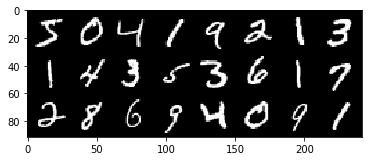

In [9]:
# create a grid of images and display them
# make a grid of 40 images, 8 images per row
X_grid = utils.make_grid(X_train[:24], nrow=8, padding=2) # padding means edge pixel

# call helper function
show(X_grid)

Text(0.5, 1.0, 'transpose')

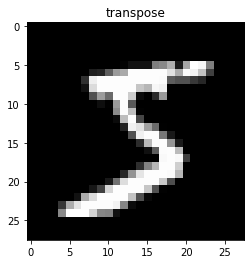

In [10]:
img = train_data[0][0]
img_np = img.numpy().squeeze(0)

plt.imshow(img_np,cmap='gray')
plt.title('transpose')

### 3. Import MNIST dataset

In [11]:
# wrap tensors into a dataset
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

In [12]:
train_loader = DataLoader(dataset = train_ds,
                        batch_size = 8,
                        shuffle=True)

val_loader = DataLoader(dataset = val_ds,
                        batch_size = 8,
                        shuffle=True)

### 4. Model Initialize

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # (1, 28, 28) --> (32, 26, 26)
        self.conv1 = nn.Conv2d(1,32,3,1)
        # Pooling : (32,26,26) --> (32,13,13)
        # (32, 13, 13) --> (64, 11, 11)
        self.conv2 = nn.Conv2d(32,64,3,1)
        # Pooling : (64, 11, 11) --> (64, 5, 5)
        # Flatten : FC layers
        self.fc1 = nn.Linear(5*5*64, 256)
        self.fc2 = nn.Linear(256, 64)
        # Class 10 (0 to 9)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, X):
        # Activation 1 : ReLU
        X = F.relu(self.conv1(X))
        # Max-pooling
        X = F.max_pool2d(X,2,2)
        # Activation 2 : ReLU
        X = F.relu(self.conv2(X))
        # Max-pooling
        X = F.max_pool2d(X,2,2)
        
        # Change shape : (16, 5, 5) --> (?, 16*5*5)
        X = X.view(-1, 5*5*64)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)
        
        
    

In [14]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [15]:
summary(model, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 11, 11]          18,496
            Linear-3                  [-1, 256]         409,856
            Linear-4                   [-1, 64]          16,448
            Linear-5                   [-1, 10]             650
Total params: 445,770
Trainable params: 445,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 1.70
Estimated Total Size (MB): 1.93
----------------------------------------------------------------


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

### 5.Training starts

In [17]:
def metrics_batch(target, output):
    # obtain output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()
    
    return corrects

In [18]:
def loss_batch(loss_func, X_b, y_b, yb_p, opt=None):
    # obtain loss
    loss = loss_func(yb_p, y_b)
    # obtain performance metric
    metric_b = metrics_batch(y_b, yb_p)
    
    if opt is not None:
        loss.backward() # Compute gradient
        opt.step() # Update parameters
        opt.zero_grad() # Set gradients to zero
        
    return loss.item(), metric_b


In [19]:
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    """
    Computes the loss and metric values for the dataset.
    """
    loss = 0.0
    metric = 0.0
    len_data = len(dataset_dl.dataset)
    
    for X_b, y_b in dataset_dl:
        X_b = X_b.type(torch.float).to(device)
        y_b = y_b.to(device)
        
        # obtain model output
        yb_p = model(X_b)
        
        # Batch
        loss_b, metric_b = loss_batch(loss_func, X_b, y_b, yb_p, opt)
        
        loss += loss_b
        if metric_b is not None:
            metric += metric_b
            
    loss /= len_data
    metric /= len_data
    
    return loss, metric

In [20]:
def train_val(epochs, model, loss_func, opt, train_loader, val_loader):
    for epoch in range(epochs):
        model.train() # convert to train mode
        train_loss, train_metric = loss_epoch(model, loss_func, train_loader, opt)
        
        model.eval() # convert to evaluation mode
        
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_loader)
            
        accuracy = 100 * val_metric
        print('epoch: %d, train loss: %.6f, val loss: %.6f, accuracy: %.2f' %(epoch+1, train_loss, val_loss, accuracy))

In [21]:
train_val(epochs, model, criterion, optimizer, train_loader, val_loader)

epoch: 0, train loss: 0.015318, val loss: 0.007766, accuracy: 98.05
epoch: 1, train loss: 0.005515, val loss: 0.005647, accuracy: 98.47
epoch: 2, train loss: 0.003497, val loss: 0.005704, accuracy: 98.62
epoch: 3, train loss: 0.002705, val loss: 0.004982, accuracy: 98.92
epoch: 4, train loss: 0.002039, val loss: 0.005466, accuracy: 98.83
epoch: 5, train loss: 0.001651, val loss: 0.004762, accuracy: 99.02
epoch: 6, train loss: 0.001166, val loss: 0.005571, accuracy: 98.97
epoch: 7, train loss: 0.001300, val loss: 0.006687, accuracy: 98.72
epoch: 8, train loss: 0.000975, val loss: 0.005612, accuracy: 98.92
epoch: 9, train loss: 0.000742, val loss: 0.005964, accuracy: 98.95
epoch: 10, train loss: 0.000813, val loss: 0.005354, accuracy: 99.06
epoch: 11, train loss: 0.000671, val loss: 0.006743, accuracy: 99.08
epoch: 12, train loss: 0.000678, val loss: 0.006537, accuracy: 99.02
epoch: 13, train loss: 0.000637, val loss: 0.005918, accuracy: 99.24
epoch: 14, train loss: 0.000476, val loss: 0

### 6. Inference

In [88]:
X = X_val
y = y_val

In [90]:
X.shape

torch.Size([10000, 1, 28, 28])

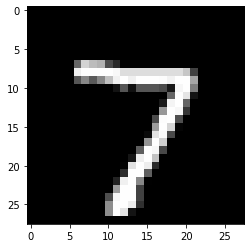

In [91]:
plt.imshow(X[0].numpy()[0],cmap='Greys_r')

In [92]:
X = X.type(torch.float)

In [39]:
X = X.to(device)

In [40]:
X.shape

torch.Size([10000, 1, 28, 28])

In [41]:
pred = model(X)

In [44]:
pred = pred.argmax(dim=1, keepdim=True)

In [76]:
print('Inference accuracy : %.2f %%' %(accuracy_score(y.cpu(),pred.cpu())*100))

Inference accuracy : 99.00 %


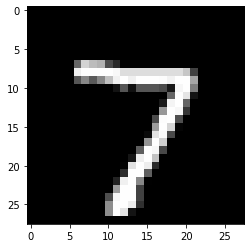

In [102]:
plt.imshow(X[0].numpy()[0],cmap='Greys_r')

Label : 2 , Prediction :  2


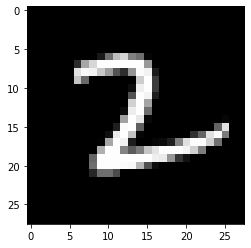

Label : 9 , Prediction :  9


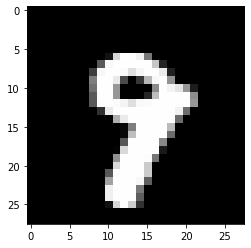

Label : 1 , Prediction :  1


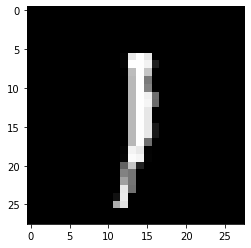

Label : 6 , Prediction :  6


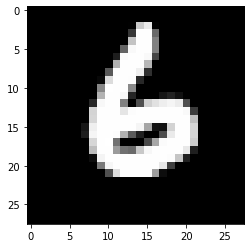

Label : 1 , Prediction :  1


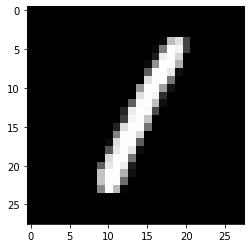

Label : 3 , Prediction :  3


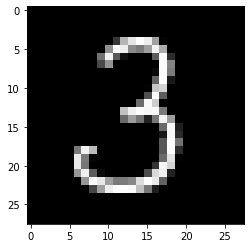

Label : 6 , Prediction :  6


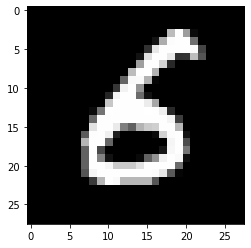

Label : 1 , Prediction :  1


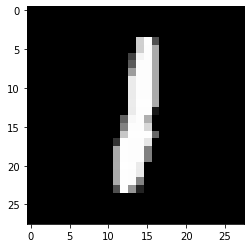

Label : 9 , Prediction :  9


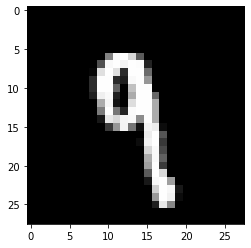

Label : 2 , Prediction :  2


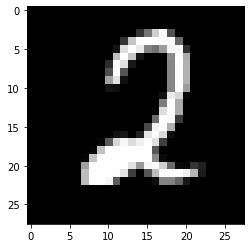

In [123]:
for x in range(10):
    rand = random.randint(0,len(pred))
    print('Label :',y[rand].numpy(),', Prediction : ',pred[rand].cpu().numpy()[0])
    plt.figure()
    plt.imshow(X[rand].numpy()[0], cmap='Greys_r')
    plt.show()

### 7. Save the model

In [125]:
weights_path = './sav/'

if not os.path.isdir(weights_path):
    os.makedirs(weights_path)
    
torch.save(model.state_dict(), weights_path+'mnist.pt')
